# Random Forest - Top model according to the SCPM of -4.96

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# Database Reading and Manipulation
import pandas as pd

# Linear Algebra
import numpy as np

# Plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Model Selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

# Modeling
from sklearn.ensemble import RandomForestRegressor

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

# Processing
from sklearn.preprocessing import StandardScaler


# Pipeline
from sklearn.pipeline import Pipeline

# Data imputation
from sklearn.impute import SimpleImputer

# Custom modules
## Model selection
from src.cross_validation.blocking_time_series_split import BlockingTimeSeriesSplit

## Function to print scores
from src.utils.print_scores import print_scores

## Function to calculate score regression metrics
from src.utils.score_regression_metrics import score_regression_metrics

## Function to fill the results metric dict
from src.utils.fill_results_dict import fill_results_dict

# Warnings
import warnings

<IPython.core.display.Javascript object>

# Functions and definitions

In [3]:
def get_random_forest_df_importances(scores):
    importances = {}
    importances_with_column = []
    columns = x.columns

    for index, pipeline in enumerate(scores["estimator"]):
        model = pipeline.named_steps["estimator"]
        importances[index] = model.feature_importances_

    for index, importances_vec in importances.items():
        importances_col = pd.DataFrame(
            {col: [c] for col, c in zip(columns, importances_vec)},
            index=[f"Importances - {index}"],
        )
        importances_with_column.append(importances_col)
    df_importances = pd.concat(importances_with_column)

    return df_importances

<IPython.core.display.Javascript object>

In [4]:
SEED = 47
METRICS = (
    "neg_root_mean_squared_error",
    "neg_mean_absolute_error",
    "neg_mean_absolute_percentage_error",
    "r2",
)
METRICS_DICT = {
    "neg_root_mean_squared_error": "RMSE",
    "neg_mean_absolute_error": "MAE",
    "neg_mean_absolute_percentage_error": "MAPE",
    "r2": "R2",
}

<IPython.core.display.Javascript object>

## Defining a dataframe structure to save the results

In [5]:
results_to_save = []

results_dict = {
    "Category": "Local Model",
    "Company": "209",
    "Plant": "S",
    "Features": "Chemical",
    "Data Shape": None,
    "Timesteps": None,
    "Model": "Random Forest",
    "Model Params": None,
    "Scaler": None,
    "Scaler Params": None,
    "Imputer": "Median",
    "Imputer Params": None,
    "Cross Validation": None,
    "Cross Validation Params": np.nan,
    "RMSE Train": np.nan,
    "MAE Train": np.nan,
    "MAPE Train": np.nan,
    "R2 Train": np.nan,
    "RMSE Test": np.nan,
    "MAE Test": np.nan,
    "MAPE Test": np.nan,
    "R2 Test": np.nan,
}

<IPython.core.display.Javascript object>

# Reading the dataset

In [6]:
# df = pd.read_csv("../../../../data/processed/partner_ii/cement-shipping.csv")
df = pd.read_csv("../../../../data/processed/209/s.csv")

<IPython.core.display.Javascript object>

## Defining Features

In this set of experiments we keep only chemical and mineralogical features yielded by the same testing method/procedure

In [7]:
df_copy = df.copy().drop(
    [
        "Cement_Type",
        "Blaine",
        "#400",
        "Final setting time",
        "Initial setting time",
        "CS3",
        "CS7",
    ],
    axis=1,
)

<IPython.core.display.Javascript object>

# 1. Decision Tree Regressor

In [8]:
PARAMS = {
    "criterion": "squared_error",
    "n_estimators": 5,
    "max_depth": 3,
    "random_state": SEED,
}

<IPython.core.display.Javascript object>

<h2>1. Dataset: df_no_cs</h2> <br>In this dataset the CS1, CS3  and CS7 variables are not considered. Only Chemical and mineralogical features measured by the same method. For this particular dataset, all chemical features, with the exception of LOI were measured by XRF and XRD methods.

In [9]:
y = df_copy.pop("CS28").values
x = df_copy.drop(["Date"], axis=1)
dates = df["Date"].copy()

<IPython.core.display.Javascript object>

## 1.2. Blocking Time Series Cross Validation

<b>Dataset shape:</b> (1234, 38)<br>
<b>Splits:</b>5<br>    
    1. 5 folds of 246 samples
    2. 50% train (123 samples each fold)
    3. 50% test (123 samples each fold)
<b>Total:</b> 5 models<br>

In [10]:
repeats = 3
n_splits = 5
train_size = 0.8

pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
        ("estimator", RandomForestRegressor(**PARAMS)),
    ]
)
cv = BlockingTimeSeriesSplit(n_splits=n_splits, train_size=train_size)
scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
    return_estimator=True,
    return_indices=True,
)
print("Blocking Time Series Split:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

results_dict_copy = results_dict.copy()
results_dict_copy["Cross Validation"] = "Blocking Time Series Split"
results_dict_copy[
    "Cross Validation Params"
] = '{"N_Splits": 5, "Repeats": 1, "train_size": 0.8}'
results_dict_copy["Data Shape"] = x.shape
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)

Blocking Time Series Split:
Repeats: 3
n_splits: 5

******
[TRAIN]
******
RMSE: -0.731 (0.061)
MAE: -0.568 (0.046)
MAPE: -0.014 (0.001)
R2: 0.980 (0.003)


******
[TEST]
******
RMSE: -1.064 (0.291)
MAE: -0.787 (0.152)
MAPE: -0.019 (0.004)
R2: 0.958 (0.025)




<IPython.core.display.Javascript object>

## Plotting the Predictions

In [11]:
df_pred = pd.DataFrame()
df_pred["DATE"] = dates.copy()
df_pred["CS28"] = y.copy()
df_pred["CS28_PRED"] = np.nan
df_pred["SET"] = ""
df_pred["CEMENT_TYPE"] = df["Cement_Type"].copy()
df_pred["DATE"] = pd.to_datetime(df_pred["DATE"])


for idx, pipeline in enumerate(scores["estimator"]):
    index_train = scores["indices"]["train"][idx]
    index_test = scores["indices"]["test"][idx]
    index_preds = np.concatenate([index_train, index_test])

    # results = scores["estimator"][0].predict(x.loc[index_preds])
    results = pipeline.predict(x.loc[index_preds])
    df_pred.loc[index_preds, "CS28_PRED"] = results.copy()
    df_pred.loc[index_train, "SET"] = "TRAIN"
    df_pred.loc[index_test, "SET"] = "TEST"
df_pred = df_pred.dropna()

<IPython.core.display.Javascript object>

In [12]:
df_pred[["DATE", "CS28", "CS28_PRED", "SET"]]

,DATE,CS28,CS28_PRED,SET
0,2021-01-02,34.200001,34.642735,TRAIN
1,2021-01-04,34.700001,34.717295,TRAIN
2,2021-01-04,46.099998,45.147487,TRAIN
3,2021-01-05,45.799999,45.147487,TRAIN
4,2021-01-05,34.599998,34.752615,TRAIN
...,...,...,...,...
1490,2023-07-15,46.500000,45.489896,TEST
1491,2023-07-18,46.500000,45.377243,TEST
1492,2023-07-18,34.400002,34.685573,TEST
1493,2023-07-19,46.099998,45.377243,TEST


<IPython.core.display.Javascript object>

In [13]:
df_copy.shape, df_pred.shape

((1495, 12), (1495, 5))

<IPython.core.display.Javascript object>

In [14]:
df_copy_merge = df_copy.merge(df_pred, left_index=True, right_index=True, how="left")
df_copy_merge["COMPANY"] = 209
df_copy_merge["PLANT"] = "S"
for fold, (train_index, test_index) in enumerate(cv.split(x)):
    df_copy_merge.loc[train_index, "FOLD"] = fold + 1
    df_copy_merge.loc[test_index, "FOLD"] = fold + 1
df_copy_merge["FOLD"] = df_copy_merge["FOLD"].astype(int)
df_copy_merge.to_excel("local_model_random_forest_btsscv_209_s.xlsx", index=False)
df_copy_merge.to_csv("local_model_random_forest_btsscv_209_s.csv", index=False)

<IPython.core.display.Javascript object>

In [15]:
matplotlib.rc_file_defaults()

<IPython.core.display.Javascript object>

In [16]:
# # Assuming your DataFrame is named 'df_pred'

# # Filter for test set predictions
# df_test = df_pred[df_pred['SET'] == 'TEST']

# # Convert DATE to datetime objects if not already
# df_test['DATE'] = pd.to_datetime(df_test['DATE'])

# # Create the plot
# fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(15, 10))
# colors = plt.cm.get_cmap("tab20").colors

# # Plot actual values
# ax.plot(df_test['DATE'], df_test['CS28'], label='Actual CS28', marker='o', linestyle='', color=colors[0])
# # Plot predicted values
# ax.plot(df_test['DATE'], df_test['CS28_PRED'], label='Predicted CS28', marker='x', linestyle='', color=colors[2])



# # Add labels and title
# ax.set_xlabel("Date", labelpad=20, fontsize=15)
# ax.set_ylabel('CS28 (MPa)', labelpad=20, fontsize=15)
# plt.title('Random Forest Model Predictions on Test Set')
# ax.legend()
# ax.grid(True)

# # Rotate x-axis labels for better readability (optional)
# plt.xticks(rotation=45)

# ax.grid(which="both")
# ax.spines["top"].set_visible(False)
# ax.spines["right"].set_visible(False)

# # Show the plot
# plt.tight_layout() # Adjust layout for better spacing
# plt.show()


<IPython.core.display.Javascript object>

In [17]:
matplotlib.rc_file_defaults()

<IPython.core.display.Javascript object>

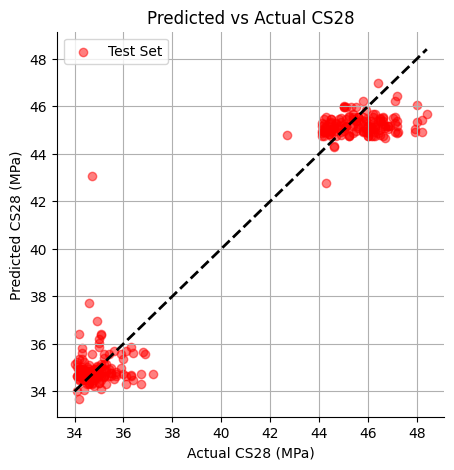

<IPython.core.display.Javascript object>

In [18]:
# Filter to only include the test set
test_data = df_pred[df_pred["SET"] == "TEST"]

# Plot Predicted vs Actual for the test set
plt.figure(figsize=(5.0, 5.0))
plt.scatter(
    test_data["CS28"], test_data["CS28_PRED"], color="red", alpha=0.5, label="Test Set"
)
plt.plot(
    [test_data["CS28"].min(), test_data["CS28"].max()],
    [test_data["CS28"].min(), test_data["CS28"].max()],
    "k--",
    lw=2,
)
plt.xlabel("Actual CS28 (MPa)")
plt.ylabel("Predicted CS28 (MPa)")
plt.title("Predicted vs Actual CS28")
plt.legend()
plt.grid(True)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig("ecics_cm_btiss_scpm_top_one_pred_vs_actual_cs28.png", dpi=300, bbox_inches='tight')

plt.show()
# USAR ESSE



In [19]:
# # Plot Predicted vs Actual for the test set
# plt.figure(figsize=(5.5, 5.5))
# plt.scatter(
#     test_data["CS28"], test_data["CS28_PRED"], color="dodgerblue", alpha=0.7, label="Test Set"
# )
# plt.plot(
#     [df_pred["CS28"].min(), df_pred["CS28"].max()],
#     [df_pred["CS28"].min(), df_pred["CS28"].max()],
#     color="black", linestyle="--", linewidth=2,
# )
# plt.xlabel("Actual CS28 (MPa)")
# plt.ylabel("Predicted CS28 (MPa)")
# plt.title("Predicted vs Actual CS28")
# plt.legend()
# plt.grid(True)
# plt.gca().spines["top"].set_visible(False)
# plt.gca().spines["right"].set_visible(False)

# plt.savefig("inn_cm_btiss_scpm_top_one_pred_vs_actual_cs28.png", dpi=300, bbox_inches='tight')
# plt.show()


<IPython.core.display.Javascript object>

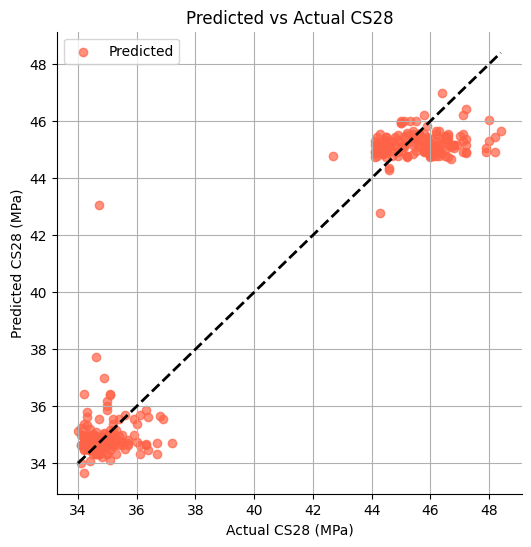

<IPython.core.display.Javascript object>

In [20]:
plt.figure(figsize=(6, 6))
plt.scatter(
    test_data["CS28"], test_data["CS28_PRED"], color="tomato", alpha=0.7, label="Predicted"
)
plt.plot(
    [test_data["CS28"].min(), test_data["CS28"].max()],
    [test_data["CS28"].min(), test_data["CS28"].max()],
    color="black", linestyle="--", linewidth=2,
)
plt.xlabel("Actual CS28 (MPa)")
plt.ylabel("Predicted CS28 (MPa)")
plt.title("Predicted vs Actual CS28")
plt.legend()
plt.grid(True)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig("ecics_cm_btiss_scpm_top_one_pred_vs_actual_cs28.png", dpi=300, bbox_inches='tight')
plt.show()


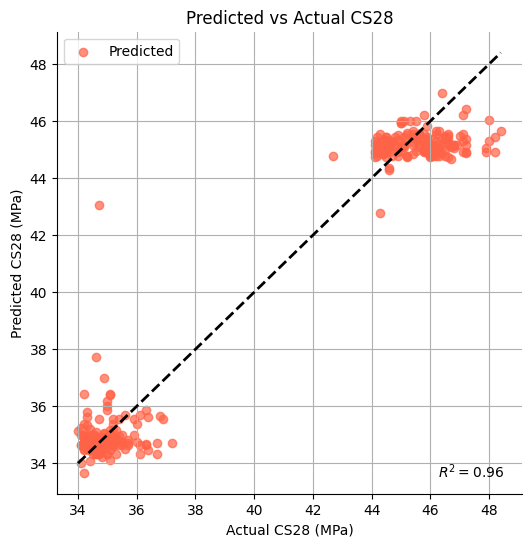

<IPython.core.display.Javascript object>

In [21]:
plt.figure(figsize=(6, 6))
plt.scatter(
    test_data["CS28"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    label="Predicted",
)
plt.plot(
    [test_data["CS28"].min(), test_data["CS28"].max()],
    [test_data["CS28"].min(), test_data["CS28"].max()],
    color="black",
    linestyle="--",
    linewidth=2,
)
plt.xlabel("Actual CS28 (MPa)")
plt.ylabel("Predicted CS28 (MPa)")
plt.title("Predicted vs Actual CS28")
plt.legend()
plt.grid(True)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

r2 = 0.96
plt.text(
    0.82,
    0.07,
    f"$R^2 = {r2:.2f}$",
    transform=plt.gca().transAxes,
    verticalalignment="top",
)

plt.savefig(
    "ecics_cm_btiss_scpm_top_one_pred_vs_actual_cs28.png", dpi=300, bbox_inches="tight"
)
plt.show()

In [22]:
test_data[
    (test_data["CS28"] > 34)
    & (test_data["CS28"] < 36)
    & (test_data["CS28_PRED"] > 42)
    & (test_data["CS28_PRED"] < 44)
]

,DATE,CS28,CS28_PRED,SET,CEMENT_TYPE
854,2022-05-31,34.700001,43.066717,TEST,CP II-Z-32


<IPython.core.display.Javascript object>

In [23]:
df_pred["CS28"][(df_pred["CS28"] < 38) & (df_pred["SET"] == "TRAIN")].describe()

count    597.000000
mean      34.962144
std        0.953028
min       32.299999
25%       34.400002
50%       34.799999
75%       35.400002
max       37.900002
Name: CS28, dtype: float64

<IPython.core.display.Javascript object>

In [24]:
df_pred["CS28"][(df_pred["CS28"] > 44) & (df_pred["SET"] == "TRAIN")].describe()

count    577.000000
mean      45.252513
std        0.900732
min       44.099998
25%       44.500000
50%       45.000000
75%       45.799999
max       48.599998
Name: CS28, dtype: float64

<IPython.core.display.Javascript object>

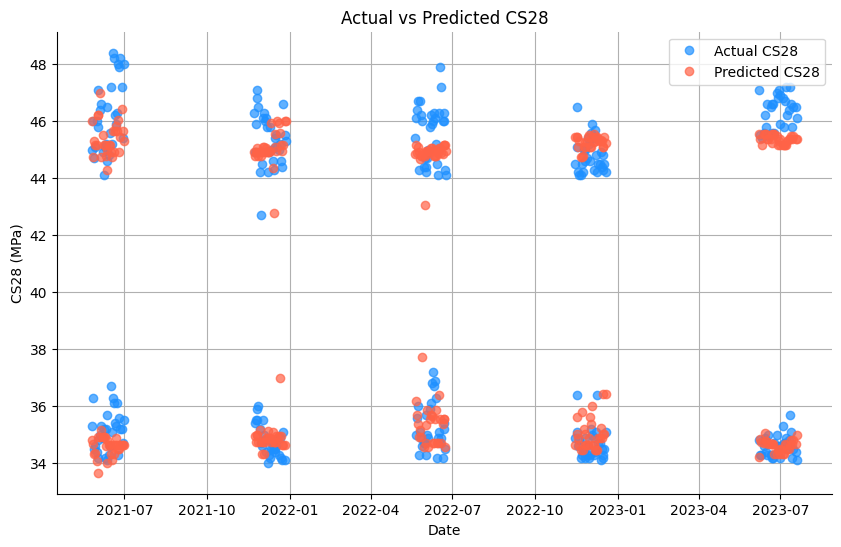

<IPython.core.display.Javascript object>

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(
    test_data["DATE"],
    test_data["CS28"],
    color="dodgerblue",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Actual CS28",
)
plt.plot(
    test_data["DATE"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Predicted CS28",
)
plt.xlabel("Date")
plt.ylabel("CS28 (MPa)")
plt.title("Actual vs Predicted CS28")
plt.legend(loc="best")
plt.grid(True)

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig(
    "ecics_cm_btiss_scpm_top_one_pred_vs_actual_cs28_over_time.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()


## Assessing Feature Importance

In [26]:
df_importances = get_random_forest_df_importances(scores)

<IPython.core.display.Javascript object>

In [27]:
df_importances

,Free CaO,CaO,MgO,Na2O,Al2O3,SiO2,SO3,K2O,Fe2O3,Loss on Ignition,Insoluble Residue
Importances - 0,0.000000,0.589263,0.004230,0.000922,0.002971,0.198032,0.002286,0.000771,0.001949,0.002611,0.196964
Importances - 1,0.002148,0.001015,0.003010,0.001972,0.197819,0.000802,0.000000,0.000989,0.000252,0.002896,0.789099
Importances - 2,0.000296,0.598021,0.001731,0.000549,0.000455,0.197853,0.000000,0.000707,0.001410,0.000769,0.198209
Importances - 3,0.001565,0.791457,0.000000,0.000856,0.000000,0.197780,0.000669,0.003191,0.001396,0.000000,0.003086
Importances - 4,0.000436,0.000274,0.000919,0.000000,0.000294,0.021634,0.000000,0.014737,0.000000,0.000381,0.961325


<IPython.core.display.Javascript object>

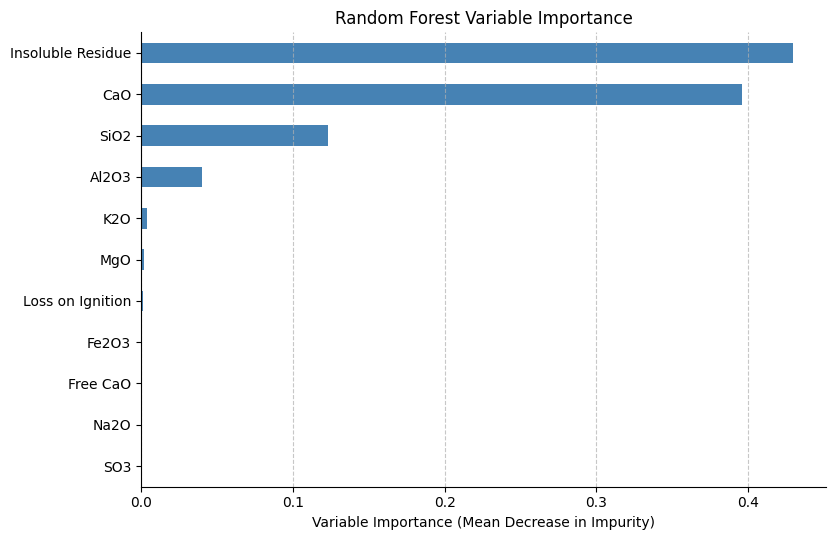

<IPython.core.display.Javascript object>

In [28]:
df_importances.mean(axis=0).sort_values().plot(
    kind="barh", figsize=(10, 5.5), color="steelblue"  # Consider using 'steelblue'
)
plt.title("Random Forest Variable Importance")
plt.xlabel("Variable Importance (Mean Decrease in Impurity)")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.tight_layout()
plt.subplots_adjust(left=0.3)
plt.show()

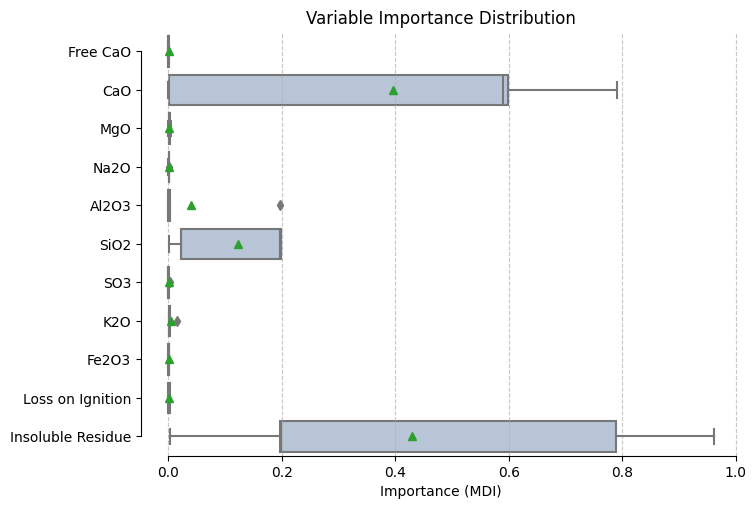

<IPython.core.display.Javascript object>

In [29]:
warnings.filterwarnings("ignore")
plt.figure(figsize=(10, 5.5))
sns.boxplot(data=df_importances, orient="h", color="lightsteelblue", saturation=0.7, showmeans=True)
sns.despine(trim=True, left=False)
plt.xlabel("Importance (MDI)")
plt.title("Variable Importance Distribution")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.show()


In [30]:
# warnings.filterwarnings("ignore")
# plt.figure(figsize=(10, 5.5))
# sns.boxplot(data=df_importances, orient="h", color="lightsteelblue", saturation=1, showmeans=True)
# sns.despine(trim=True, left=False)
# plt.xlabel("Relevance (MDI)")
# plt.title("Variable Relevance Distribution")
# plt.grid(axis='x', linestyle='--', alpha=0.7)
# plt.subplots_adjust(left=0.3)
# plt.show()


<IPython.core.display.Javascript object>

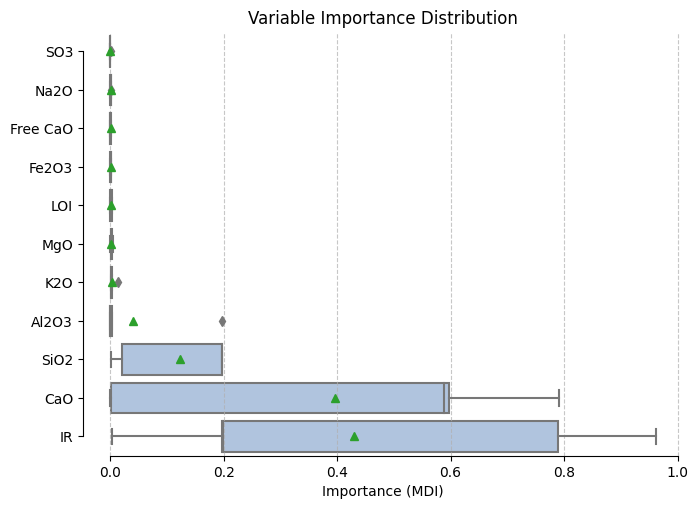

<IPython.core.display.Javascript object>

In [31]:
# Calculate the means of the importance scores
mean_importances = df_importances.mean()

# Sort the features by their mean relevance
sorted_features = mean_importances.sort_values()

# Re-order the DataFrame according to the sorted features
df_importances_sorted = df_importances[sorted_features.index]

# Plot the sorted boxplot
df_importances_sorted = df_importances_sorted.rename(
    columns={"Loss on Ignition": "LOI", "Insoluble Residue": "IR"}
)

plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=df_importances_sorted,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Importance (MDI)")
plt.title("Variable Importance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig("ecics_cm_btiss_random_forest_scpm_best_dist_var_relevance.png", dpi=300, bbox_inches='tight')
plt.show()


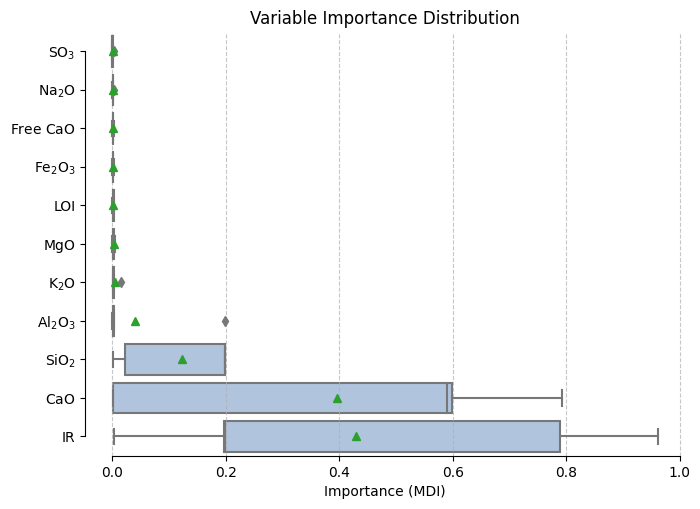

<IPython.core.display.Javascript object>

In [32]:
# Backup the original backend
original_backend = plt.get_backend()

# Use Matplotlib's default backend
# plt.switch_backend("agg")  # or any backend you prefer

# Update font settings to default
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans"],
        "font.size": 10,
        "text.usetex": False,  # Use MathText, not LaTeX
    }
)


# Convert chemical formulas using MathText syntax
df_importances_sorted_plot = df_importances_sorted.rename(
    columns={
        "K2O": r"$\mathrm{K_2O}$",
        "Free CaO": r"Free $\mathrm{CaO}$",
        "Total C2S": r"Total $\mathrm{C_2S}$",
        "Na2O": r"$\mathrm{Na_2O}$",
        "CaO": r"$\mathrm{CaO}$",
        "SiO2": r"$\mathrm{SiO_2}$",
        "MgO": r"$\mathrm{MgO}$",
        "Fe2O3": r"$\mathrm{Fe_2O_3}$",
        "Al2O3": r"$\mathrm{Al_2O_3}$",
        "Total C3S": r"Total $\mathrm{C_3S}$",
        "C3A": r"$\mathrm{C_3A}$",
        "C4AF": r"$\mathrm{C_4AF}$",
        "LOI": "LOI",
        "SO3": r"$\mathrm{SO_3}$",
        "Insoluble Residue": "IR",
    }
)

plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=df_importances_sorted_plot,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Importance (MDI)")
plt.title("Variable Importance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "ecics_cm_btiss_random_forest_scpm_best_dist_var_relevance.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()


# Step 3: Reset all rcParams to their default values
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcdefaults()

# Switch back to the original backend
plt.switch_backend(original_backend)

In [33]:
df_importances

,Free CaO,CaO,MgO,Na2O,Al2O3,SiO2,SO3,K2O,Fe2O3,Loss on Ignition,Insoluble Residue
Importances - 0,0.000000,0.589263,0.004230,0.000922,0.002971,0.198032,0.002286,0.000771,0.001949,0.002611,0.196964
Importances - 1,0.002148,0.001015,0.003010,0.001972,0.197819,0.000802,0.000000,0.000989,0.000252,0.002896,0.789099
Importances - 2,0.000296,0.598021,0.001731,0.000549,0.000455,0.197853,0.000000,0.000707,0.001410,0.000769,0.198209
Importances - 3,0.001565,0.791457,0.000000,0.000856,0.000000,0.197780,0.000669,0.003191,0.001396,0.000000,0.003086
Importances - 4,0.000436,0.000274,0.000919,0.000000,0.000294,0.021634,0.000000,0.014737,0.000000,0.000381,0.961325


<IPython.core.display.Javascript object>

In [34]:
df_importances.describe().T

,count,mean,std,min,25%,50%,75%,max
Free CaO,5.0,0.000889,0.000920,0.000000,0.000296,0.000436,0.001565,0.002148
CaO,5.0,0.396006,0.369852,0.000274,0.001015,0.589263,0.598021,0.791457
MgO,5.0,0.001978,0.001676,0.000000,0.000919,0.001731,0.003010,0.004230
Na2O,5.0,0.000860,0.000720,0.000000,0.000549,0.000856,0.000922,0.001972
Al2O3,5.0,0.040308,0.088059,0.000000,0.000294,0.000455,0.002971,0.197819
SiO2,5.0,0.123220,0.102509,0.000802,0.021634,0.197780,0.197853,0.198032
SO3,5.0,0.000591,0.000991,0.000000,0.000000,0.000000,0.000669,0.002286
K2O,5.0,0.004079,0.006047,0.000707,0.000771,0.000989,0.003191,0.014737
Fe2O3,5.0,0.001001,0.000835,0.000000,0.000252,0.001396,0.001410,0.001949
Loss on Ignition,5.0,0.001331,0.001330,0.000000,0.000381,0.000769,0.002611,0.002896


<IPython.core.display.Javascript object>

In [35]:
df_importances.mean(axis=0)

Free CaO             0.000889
CaO                  0.396006
MgO                  0.001978
Na2O                 0.000860
Al2O3                0.040308
SiO2                 0.123220
SO3                  0.000591
K2O                  0.004079
Fe2O3                0.001001
Loss on Ignition     0.001331
Insoluble Residue    0.429736
dtype: float64

<IPython.core.display.Javascript object>

In [36]:
df_importances.std(axis=0, ddof=0)

Free CaO             0.000823
CaO                  0.330806
MgO                  0.001499
Na2O                 0.000644
Al2O3                0.078763
SiO2                 0.091687
SO3                  0.000886
K2O                  0.005408
Fe2O3                0.000747
Loss on Ignition     0.001190
Insoluble Residue    0.374579
dtype: float64

<IPython.core.display.Javascript object>

In [37]:
df_copy.nunique()

Date                  751
Free CaO              184
CaO                  1339
MgO                  1007
Na2O                  167
Al2O3                 874
SiO2                 1207
SO3                   513
K2O                   572
Fe2O3                 602
Loss on Ignition      341
Insoluble Residue     570
dtype: int64

<IPython.core.display.Javascript object>

In [38]:
pipeline.named_steps

{'imputer': SimpleImputer(strategy='median'),
 'estimator': RandomForestRegressor(max_depth=3, n_estimators=5, random_state=47)}

<IPython.core.display.Javascript object>

In [39]:
from sklearn.inspection import permutation_importance

<IPython.core.display.Javascript object>

In [40]:
# Initialize lists to store importance results
mdi_importances = []
perm_importances = []

# Compute feature importances
for i, (train_idx, test_idx) in enumerate(cv.split(x, y)):
    pipeline.fit(x.iloc[train_idx], y[train_idx])

    # Extract the trained model
    model = pipeline.named_steps["estimator"]
    imputer = pipeline.named_steps["imputer"]
    # Compute MDI importance
    mdi_importances.append(model.feature_importances_)

    # Compute permutation importance
    result = permutation_importance(
        model,
        imputer.transform(x.iloc[test_idx]),
        y[test_idx],
        n_repeats=10,
        random_state=SEED,
        n_jobs=-1,
        scoring="r2",
    )
    perm_importances.append(result.importances_mean)

<IPython.core.display.Javascript object>

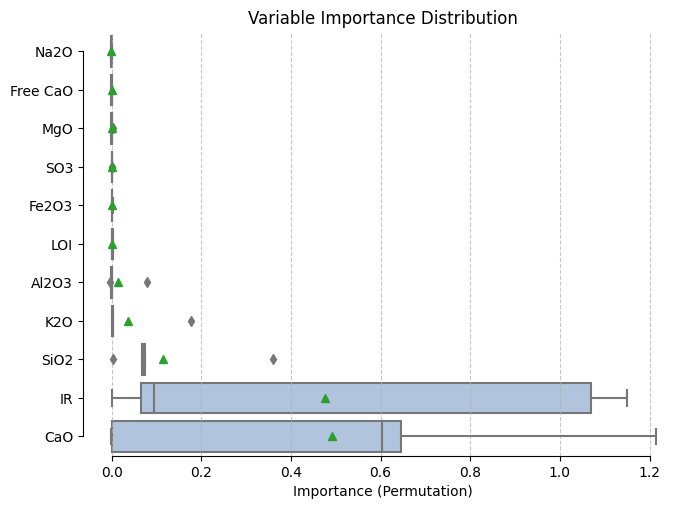

<IPython.core.display.Javascript object>

In [41]:
# Convert lists to DataFrames
mdi_importances_df = pd.DataFrame(mdi_importances, columns=x.columns)
perm_importances_df = pd.DataFrame(perm_importances, columns=x.columns)


# Calculate the mean importance for each feature
mean_importances = perm_importances_df.mean().sort_values()

# Reorder the DataFrame columns based on mean importance
perm_importances_df = perm_importances_df[mean_importances.index]

perm_importances_df = perm_importances_df.rename(
    columns={"Loss on Ignition": "LOI", "Insoluble Residue": "IR"}
)


plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=perm_importances_df,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Importance (Permutation)")
plt.title("Variable Importance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "ecics_cm_btiss_random_forest_scpm_best_dist_var_perm_relevance.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

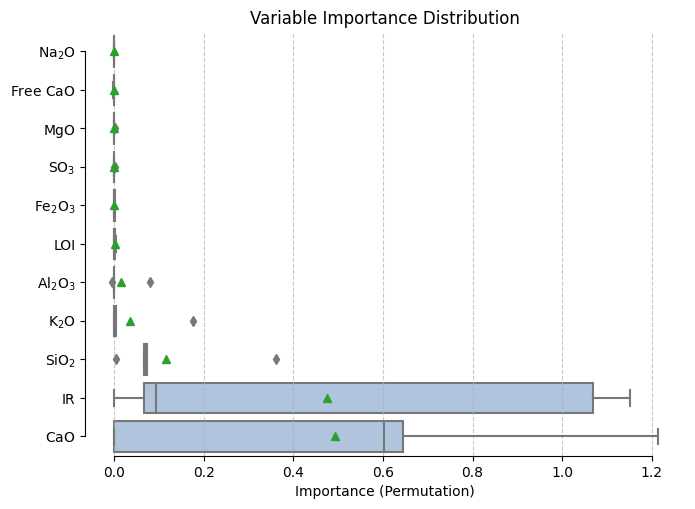

<IPython.core.display.Javascript object>

In [42]:
# Backup the original backend
original_backend = plt.get_backend()

# Use Matplotlib's default backend
# plt.switch_backend("agg")  # or any backend you prefer

# Update font settings to default
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans"],
        "font.size": 10,
        "text.usetex": False,  # Use MathText, not LaTeX
    }
)


# Convert chemical formulas using MathText syntax
perm_importances_df_plot = perm_importances_df.rename(
    columns={
        "K2O": r"$\mathrm{K_2O}$",
        "Free CaO": r"Free $\mathrm{CaO}$",
        "Total C2S": r"Total $\mathrm{C_2S}$",
        "Na2O": r"$\mathrm{Na_2O}$",
        "CaO": r"$\mathrm{CaO}$",
        "SiO2": r"$\mathrm{SiO_2}$",
        "MgO": r"$\mathrm{MgO}$",
        "Fe2O3": r"$\mathrm{Fe_2O_3}$",
        "Al2O3": r"$\mathrm{Al_2O_3}$",
        "Total C3S": r"Total $\mathrm{C_3S}$",
        "C3A": r"$\mathrm{C_3A}$",
        "C4AF": r"$\mathrm{C_4AF}$",
        "LOI": "LOI",
        "SO3": r"$\mathrm{SO_3}$",
        "Insoluble Residue": "IR",
    }
)

plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=perm_importances_df_plot,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Importance (Permutation)")
plt.title("Variable Importance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "ecics_cm_btiss_random_forest_scpm_best_dist_var_perm_relevance.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()


# Step 3: Reset all rcParams to their default values
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcdefaults()

# Switch back to the original backend
plt.switch_backend(original_backend)

In [43]:
perm_importances_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Na2O,5.0,-0.000410,0.000424,-0.000818,-0.000675,-0.000653,0.000000,0.000095
Free CaO,5.0,-0.000093,0.000850,-0.001277,-0.000515,0.000000,0.000378,0.000947
MgO,5.0,0.000198,0.001406,-0.000863,-0.000630,-0.000152,0.000000,0.002634
SO3,5.0,0.000237,0.000619,-0.000151,0.000000,0.000000,0.000000,0.001338
Fe2O3,5.0,0.000576,0.000961,-0.000200,-0.000071,0.000000,0.001164,0.001988
LOI,5.0,0.001192,0.001728,-0.000010,0.000000,0.000050,0.002085,0.003833
Al2O3,5.0,0.015145,0.035975,-0.003361,-0.000512,0.000000,0.000153,0.079448
K2O,5.0,0.036742,0.078243,0.000000,0.000755,0.002346,0.003927,0.176680
SiO2,5.0,0.115693,0.140038,0.003919,0.067968,0.072064,0.073837,0.360675
IR,5.0,0.476151,0.579955,0.000836,0.066581,0.094183,1.068568,1.150586


<IPython.core.display.Javascript object>

In [44]:
perm_importances_df

,Na2O,Free CaO,MgO,SO3,Fe2O3,LOI,Al2O3,K2O,SiO2,IR,CaO
0,-0.000818,0.000000,0.002634,0.001338,0.001988,-0.000010,-0.003361,0.003927,0.072064,0.066581,0.645733
1,-0.000675,0.000378,-0.000630,0.000000,-0.000071,0.002085,0.079448,0.000000,0.003919,1.150586,0.000091
2,0.000095,-0.000515,-0.000863,0.000000,0.001164,0.003833,-0.000512,0.002346,0.067968,0.094183,0.602677
3,-0.000653,0.000947,0.000000,-0.000151,-0.000200,0.000000,0.000000,0.000755,0.073837,0.000836,1.213380
4,0.000000,-0.001277,-0.000152,0.000000,0.000000,0.000050,0.000153,0.176680,0.360675,1.068568,-0.000375


<IPython.core.display.Javascript object>

In [45]:
perm_importances_df.mean(axis=0)

Na2O       -0.000410
Free CaO   -0.000093
MgO         0.000198
SO3         0.000237
Fe2O3       0.000576
LOI         0.001192
Al2O3       0.015145
K2O         0.036742
SiO2        0.115693
IR          0.476151
CaO         0.492301
dtype: float64

<IPython.core.display.Javascript object>

In [46]:
perm_importances_df.std(axis=0, ddof=0)

Na2O        0.000379
Free CaO    0.000760
MgO         0.001257
SO3         0.000553
Fe2O3       0.000859
LOI         0.001546
Al2O3       0.032177
K2O         0.069982
SiO2        0.125254
IR          0.518728
CaO         0.456219
dtype: float64

<IPython.core.display.Javascript object>

In [47]:
from sklearn.metrics import make_scorer

def compute_scmp(y_true, y_pred):
    # Compute the performance metrics
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)

    # Create a DataFrame with these metrics
    metrics_df = pd.DataFrame({
        "RMSE Test": [rmse],
        "MAE Test": [mae],
        "MAPE Test": [mape],
        "R2 Test": [r2]
    })

    # Standardize the metrics
    scaler = StandardScaler(with_mean=False)
    standardized_metrics = scaler.fit_transform(metrics_df)

    # Creating a new DataFrame with standardized values
    standardized_df = pd.DataFrame(
        standardized_metrics,
        columns=["RMSE Test", "MAE Test", "MAPE Test", "R2 Test"],
    )

    # Compute SCPM: sum errors and subtract R2
    scpm = (
        standardized_df["RMSE Test"]
        + standardized_df["MAE Test"]
        + standardized_df["MAPE Test"]
        - standardized_df["R2 Test"]
    )

    return scpm.iloc[0]  # Return the scalar SCPM score

# Convert the SCPM function to a scorer that can be used in permutation_importance
scmp_scorer = make_scorer(compute_scmp, greater_is_better=False)


<IPython.core.display.Javascript object>